# First order methods for regression models

## Aim

The aim of this practical is to implement:
- gradient descent (GD);
- accelerated gradient descent (AGD);
- coordinate gradient descent (CD);
- stochastic gradient descent (SGD);
- stochastic average gradient descent (SAG);
- stochastic variance reduced gradient descent (SVRG);

for the linear regression and logistic regression models, with the ridge penalization.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work, using the **moodle platform**.
- This means that **each student in the pair sends the same file**.

# Gentle reminder: no evaluation if you don't respect this EXACTLY.

## To generate the name of your file, use the following.

In [47]:
# Change here using your first and last names
fn1 = "bonnie"
ln1 = "parker"
fn2 = "clyde"
ln2 = "barrow"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_parker_bonnie_and_barrow_clyde.ipynb


# Table of content

[1. Introduction](#intro)<br>
[2. Models gradients and losses](#models)<br>
[3. Solvers](#solvers)<br>
[4. Comparison of all algorithms](#comparison)<br>

<a id='intro'></a>
# 1. Introduction

## 1.1. Importing useful packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

## 1.2. Simulation of a linear model

In [3]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(w0, n_samples=1000, corr=0.5, std=0.5):
    """Simulation of a linear regression model with Gaussian features
    and a Toeplitz covariance, with Gaussian noise.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features
    
    std : `float`, default=0.5
        Standard deviation of the noise

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian  vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    y = X.dot(w0) + std * randn(n_samples)
    return X, y

C:\Users\maxrl\AppData\Local\Temp\ipykernel_2656\2152093789.py:2: DeprecationWarning: Please use `toeplitz` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import toeplitz


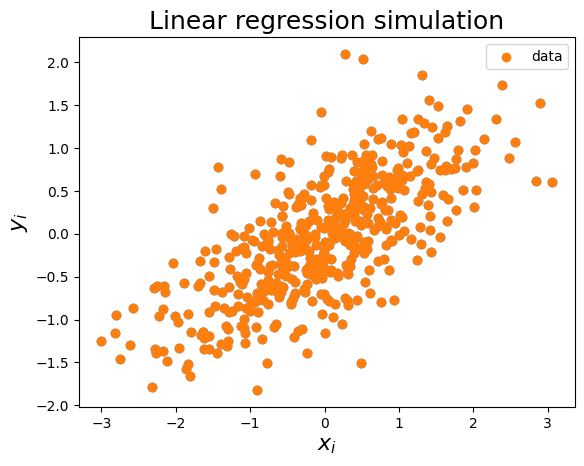

In [4]:
n_samples = 500
w0 = np.array([0.5])

X, y = simu_linreg(w0, n_samples=n_samples, corr=0.3, std=0.5)
plt.scatter(X, y)
plt.xlabel(r"$x_i$", fontsize=16)
plt.ylabel(r"$y_i$", fontsize=16)
plt.title("Linear regression simulation", fontsize=18)
plt.scatter(X, y, label='data')
plt.legend()

## 1.3. Simulation of a logistic regression model

In [5]:
def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)    
    out[idx] = 1 / (1. + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(w0, n_samples=1000, corr=0.4):
    """Simulation of a logistic regression model with Gaussian features
    and a Toeplitz covariance.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    cov = toeplitz(corr ** np.arange(0, n_features))
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(X.dot(w0))
    y = np.random.binomial(1, p, size=n_samples)
    # Put the label in {-1, 1}
    y[:] = 2 * y - 1
    return X, y

Text(0.5, 1.0, 'Logistic regression simulation')

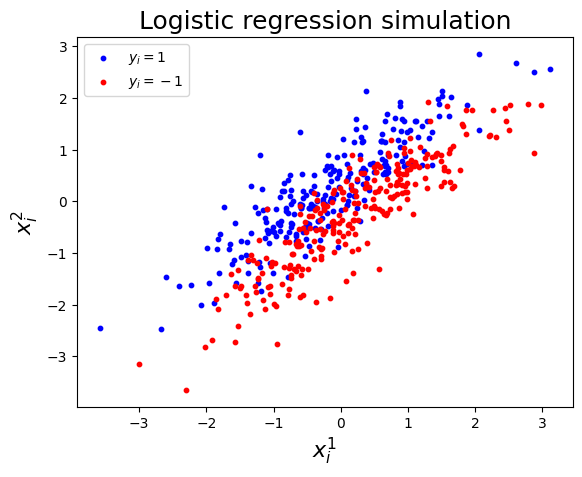

In [6]:
n_samples = 500
w0 = np.array([-3, 3.])

X, y = simu_logreg(w0, n_samples=n_samples, corr=0.8)

plt.scatter(*X[y == 1].T, color='b', s=10, label=r'$y_i=1$')
plt.scatter(*X[y == -1].T, color='r', s=10, label=r'$y_i=-1$')
plt.legend(loc='upper left')
plt.xlabel(r"$x_i^1$", fontsize=16)
plt.ylabel(r"$x_i^2$", fontsize=16)
plt.title("Logistic regression simulation", fontsize=18)

<a id='models'></a>
# 2. Models gradients and losses

We want to minimize a goodness-of-fit function $h : \mathbb R^d \to \mathbb R$ with ridge regularization, namely
$$
\arg\min_{w \in \mathbb R^d} f(w),
\qquad \text{with} \quad
f(w) = h(w) + \frac{\lambda}{2} \|w\|_2^2,
$$
where $d$ is the number of features and where we will assume that $h$ is $L$-smooth.
We will consider below the following cases.

**Linear regression**
$$
f(w)
= \frac{1}{2 n} \| y - X w \|_2^2 + \frac{\lambda}{2} \|w\|_2^2
= \frac 1n \sum_{i=1}^n f_i(w),
\qquad \text{with} \quad
f_i(w) = \frac 12 \left( (y_i - x_i^\top w)^2 + \lambda \|w\|_2^2 \right),
$$
where $n$ is the sample size, $y = [y_1 \cdots y_n]$ is the vector of labels and $X$ is the matrix of features with lines containing the features vectors $x_i \in \mathbb R^d$.

**Logistic regression**
$$
f(w)
= \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i x_i^\top w)) + \frac{\lambda}{2} \|w\|_2^2
= \frac 1n \sum_{i=1}^n f_i(w),
\qquad \text{with} \quad
f_i(w) = \log(1 + \exp(-y_i x_i^\top w)) + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, and where labels $y_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f(w)$ and its gradient $\nabla f(w)$ (along with its Lipschitz constant $L$), in order to solve this problem, as well as $\nabla f_i(w)$ (along with the biggest Lipschitz constant $L_{max}$ of $\nabla f_i(w),\dots, \nabla f_n(w)$) for stochastic gradient descent methods and $\frac{\partial f(w)}{\partial w_j}$ (along with its Lipschitz constant $L_j$) for coordinate descent.

Below is the full implementation for linear regression, where:
- `X` is the data matrix $X$;
- `y` is the vector of labels $y$;
- `strength` is the penalty coefficient $\lambda$;
- `loss(w)` computes $f(w)$;
- `grad(w)` computes $\nabla f(w)$;
- `grad_i(i, w)` computes $\nabla f_i(w)$;
- `grad_coordinate(j, w)` computes $\frac{\partial f(w)}{\partial w_j}$;
- `lip()` returns $L$;
- `lip_coordinates()` returns the vector $[L_1, \dots, L_d]$;
- `lip_max()` returns $L_{max}$.

## 2.1 Linear regression

In [7]:
from numpy.linalg import norm


class ModelLinReg:
    """A class giving first order information for linear regression
    with least-squares loss
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape

    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return 0.5 * norm(y - X.dot(w)) ** 2 / n_samples + strength * norm(w) ** 2 / 2
    
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X.T.dot(X.dot(w) - y) / n_samples + strength * w

    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i = self.X[i]
        y = self.y
        return (x_i.dot(w) - y[i]) * x_i + self.strength * w

    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X[:, j].T.dot(X.dot(w) - y) / n_samples + strength * w[j]

    def lip(self):
        """Computes the Lipschitz constant of the gradient of f"""
        X, n_samples = self.X, self.n_samples
        return norm(X.T.dot(X), 2) / n_samples + self.strength

    def lip_coordinates(self):
        """Computes the Lipschitz constant of the partial derivative of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples
        return (X ** 2).sum(axis=0) / n_samples + self.strength
        
    def lip_max(self):
        """Computes the maximum of the lipschitz constants of the gradient of f_i"""
        X, n_samples = self.X, self.n_samples
        return ((X ** 2).sum(axis=1) + self.strength).max()

## 2.2 Checks for the linear regression model

C:\Users\maxrl\AppData\Local\Temp\ipykernel_2656\1934092684.py:9: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(w0, use_line_collection=True)


Text(0.5, 1.0, 'Model weights')

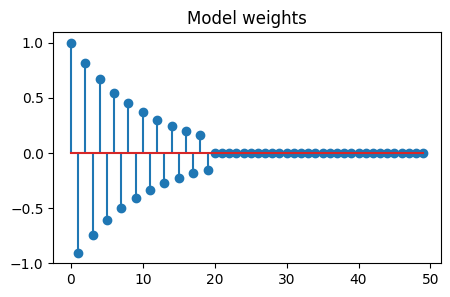

In [8]:
## Simulation setting
n_features = 50
n_informative = 20
idx = np.arange(n_features)
w0 = (-1) ** idx * np.exp(-idx / 10.)
w0[n_informative:] = 0.

plt.figure(figsize=(5, 3))
plt.stem(w0, use_line_collection=True)
plt.title("Model weights")

In [9]:
from scipy.optimize import check_grad

X, y = simu_linreg(w0, corr=0.6)
model = ModelLinReg(X, y, strength=1e-3)

w = np.random.randn(n_features)

print(check_grad(model.loss, model.grad, w)) # This must be a number (of order 1e-6)

1.3702810260408596e-06


In [10]:
print("lip =", model.lip())
print("lip_max =", model.lip_max())
print("lip_coordinates =", model.lip_coordinates())

lip = 4.223156622174965
lip_max = 102.89271355905954
lip_coordinates = [1.11 1.06 0.99 1.02 0.97 0.96 1.08 0.98 1.01 1.06 1.01 1.01 1.09 0.98
 0.95 1.   1.03 1.04 0.99 1.05 1.08 1.03 0.98 0.99 1.02 0.98 0.99 1.
 0.98 1.05 1.   1.02 1.02 1.01 1.01 1.06 1.01 0.96 1.1  0.95 0.9  0.9
 1.   0.98 0.96 0.96 0.93 1.04 1.02 1.03]


## 2.3 Logistic regression

**NB**: you can skip these questions and go to the solvers implementation, and come back here later.

### QUESTIONS

1. Compute (on paper) the gradient $\nabla f$, the gradient $\nabla f_i$ and the partial derivatives $\frac{\partial f(w)}{\partial w_j}$ of $f$ for logistic regression (fill the class given below).

2. Fill in the functions below for the computation of $f$, $\nabla f$, $\nabla f_i$ and $\frac{\partial f(w)}{\partial w_j}$ for logistic regression in the ModelLogReg class (fill between `TODO` and `END TODO`).

**Answer:**
…

In [11]:
class ModelLogReg:
    """A class giving first order information for logistic regression
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape

In [12]:
# Answer
def LRloss(self, w):
    """Computes f(w)"""
    y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
    ###

    LRloss=0
    #for i in range(n_samples):
        
    LRloss=np.log(1+np.exp(-np.multiply(y, (X@w))))
    LRloss=np.sum(LRloss)/n_samples
    LRloss+=(strength/2)*np.dot(w,w)
    return(LRloss)
    
    ### END
    
ModelLogReg.loss = LRloss

In [13]:
# Check the method with fake data
np.random.seed()
X = np.random.randn(5, 2)
y = np.random.randint(0, 2, X.shape[0])*2 - 1
w = np.random.randn(X.shape[1])

model_logreg = ModelLogReg(X, y, strength=1e-3)


model_logreg.loss(w)

1.313236676017004

In [14]:
# Answer
def LRgrad(self, w):
    
    """Computes the gradient of f at w"""
    y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
    ### TODO

    expo= np.exp(-1*(y * (X@w)))
    #print(expo.shape)
    X=X/(1+expo[:, np.newaxis])
    y=-1*y*expo
    gradMatrix=X*(y[:, np.newaxis])
    LRgrad=(gradMatrix.T@np.ones(len(y)))/n_samples

    LRgrad+=strength*w
    return(LRgrad)
    
    
    ### END TODO
    
ModelLogReg.grad = LRgrad

In [15]:
# Check the method
model_logreg.grad(w)

array([-0.05, -0.67])

In [16]:
# Answer
def LRgrad_i(self, i, w):
    """Computes the gradient of f_i at w"""
    x_i = self.X[i]
    y = self.y
    strength=self.strength
    ### TODO

    ex=np.exp(-y[i]*np.dot(x_i,w))
    LRgrad_i=-(y[i]*ex)/(1+ex)*x_i
    LRgrad_i+=strength*w
    return(LRgrad_i)

    ### END TODO
    
ModelLogReg.grad_i = LRgrad_i

In [17]:
# Check the method
model_logreg.grad_i(0, w)

array([-0.23,  0.21])

In [18]:
# Answer
def LRgrad_coordinate(self, j, w):
    """Computes the partial derivative of f with respect to 
    the j-th coordinate"""
    y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
    ### TODO

    expo= np.exp(-1*np.multiply(y,(X@w)))
    X=X[:,j]*(1/(1+expo))
    y=-1*y*expo
    gradVector=X*y
    LRgrad=np.sum(gradVector)/n_samples + strength*w[j]
    return(LRgrad)

    ### END TODO
    
ModelLogReg.grad_coordinate = LRgrad_coordinate

In [19]:
# Check the method
model_logreg.grad_coordinate(0, w)

-0.05148100321524609

In [20]:
# Answer
def LRlip(self):
    """Computes the Lipschitz constant of the gradient of f"""
    X, n_samples, strength = self.X, self.n_samples, self.strength
    ### TODO

    eigenvalues=np.linalg.eigvals(X.T@X)
    lamb=np.max(eigenvalues)
    X_sum=np.sum(np.linalg.norm(X[i,:])**2 for i in range(len(X)))
    return((1/4)*lamb-strength)    

    ### END TODO
    
ModelLogReg.lip = LRlip

In [21]:
# Check the method
model_logreg.lip()

C:\Users\maxrl\AppData\Local\Temp\ipykernel_2656\2110609988.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  X_sum=np.sum(np.linalg.norm(X[i,:])**2 for i in range(len(X)))


1.946349386674335

In [22]:
# Answer
def LRlip_coordinates(self):
    """Computes the Lipschitz constant of the partial derivative of f with respect to 
    the j-th coordinate"""
    X, n_samples = self.X, self.n_samples
    ### TODO

    return (1/4)*(X ** 2).sum(axis=0) / n_samples + self.strength

    ### END TODO
    
ModelLogReg.lip_coordinates = LRlip_coordinates

In [23]:
# Check the method
model_logreg.lip_coordinates()

array([0.11, 0.38])

In [24]:
# Answer
def LRlip_max(self):
    """Computes the maximum of the lipschitz constants of the gradient of f_i"""
    X, n_samples = self.X, self.n_samples
    ### TODO
    return ((1/4)*(X ** 2).sum(axis=1) + self.strength).max()

    ### END TODO
    
ModelLogReg.lip_max = LRlip_max

In [25]:
# Check the method
model_logreg.lip_max()

1.0860532137522503

## 2.4 Checks for the logistic regression model

### QUESTIONS

1. Check numerically the gradient using the function ``checkgrad`` from ``scipy.optimize``, as done for linear regression above.

**Remark**: use the function `simu_logreg` to simulate data according to the logistic regression model.

In [26]:
# Answer

strenght=0.5
n_samples = 500
w0 = np.array([-3, 3.])
X, y = simu_logreg(w0, n_samples=n_samples, corr=0.4)
model=ModelLogReg(X, y, strenght)

check=0
n=0
xlist=np.linspace(-3,3, 100)
ylist=np.linspace(-3,3, 100)
for x in xlist:
    for y in ylist:
        check+=check_grad(model.loss, model.grad, [x, y])
        n=n+1
check=check/n

"average error"
print(check)



2.437090252952846e-08


<a id='solvers'></a>
## 3. Solvers

We now have classes `ModelLinReg` and `ModelLogReg` that allow to compute $f(w)$, $\nabla f(w)$, 
$\nabla f_i(w)$ and $\frac{\partial f(w)}{\partial w_j}$ for the objective $f$
given by linear and logistic regression.

We want now to implement and compare several solvers to minimize $f$.

<a id='tools'></a>
## 3.1. Tools for the solvers

In [27]:
# Starting point of all solvers
w0 = np.zeros(model.n_features)

# Number of iterations
n_iter = 50

# Random samples indices for the stochastic solvers (sgd, sag, svrg)
idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)

In [28]:
# Method used to print the objective value at each iteration
# It is not necessary to read/understand it
def inspector(model, n_iter, verbose=True):
    """A closure called to update metrics after each iteration.
    Don't even look at it, we'll just use it in the solvers."""
    objectives = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(w):
        obj = model.loss(w)
        objectives.append(obj)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8)]))
            it[0] += 1
    inspector_cl.objectives = objectives
    return inspector_cl

<a id='gd'></a>
## 3.2 Gradient descent

### QUESTIONS

1. Finish the function `gd` below that implements the gradient descent algorithm.
1. Test it using the next cell.

In [29]:
# Answer
def gd(model, w0, n_iter, callback, verbose=True):
    """Gradient descent
    """
    step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    if verbose:
        print("Lauching GD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        grad=model.grad(w)
        w=w-step*grad
        ### END TODO
        callback(w)
    return w

In [30]:
callback_gd = inspector(model, n_iter=n_iter)
w_gd = gd(model, w0, n_iter=n_iter, callback=callback_gd)

Lauching GD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 6.90e-01
      20 | 6.86e-01
      30 | 6.83e-01
      40 | 6.81e-01
      50 | 6.78e-01


C:\Users\maxrl\AppData\Local\Temp\ipykernel_2656\2110609988.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  X_sum=np.sum(np.linalg.norm(X[i,:])**2 for i in range(len(X)))


<a id='agd'></a>
## 3.3 Accelerated gradient descent

### QUESTIONS

1. Finish the function `agd` below that implements the accelerated gradient descent algorithm.
1. Test it using the next cell.

In [31]:
# Answer
def agd(model, w0, n_iter, callback, verbose=True):
    """Accelerated gradient descent
    """
    step = 1 / model.lip()
    w = w0.copy()
    # Extra variables are required for acceleration
    z = w0.copy()
    z_new = w0.copy()
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching AGD solver...")
    wmid=np
    for k in range(n_iter + 1):
        ### TODO
        grad=model.grad(w)
        z=z_new

        z_new=w-step*grad


        t_new=(1+np.sqrt(1+ 4*(t**2)))/2
        B=(t-1)/t_new
        t=t_new

        w=z_new+B*(z_new-z)

        ### END TODO        
        callback(w)
    return w

In [32]:
callback_agd = inspector(model, n_iter=n_iter)
w_agd = agd(model, w0, n_iter=n_iter, callback=callback_agd)

Lauching AGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 6.85e-01
      20 | 6.71e-01
      30 | 6.58e-01
      40 | 6.49e-01
      50 | 6.44e-01


C:\Users\maxrl\AppData\Local\Temp\ipykernel_2656\2110609988.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  X_sum=np.sum(np.linalg.norm(X[i,:])**2 for i in range(len(X)))


<a id='cgd'></a>

## 3.4 Coordinate gradient descent

### QUESTIONS

1. Finish the function `cgd` below that implements the coordinate gradient descent algorithm.
1. Test it using the next cell.

In [33]:
# Answer
def cgd(model, w0, n_iter, callback, verbose=True):
    """Coordinate gradient descent
    """
    w = w0.copy()
    n_features = model.n_features
    steps = 1 / model.lip_coordinates()

    if verbose:
        print("Lauching CGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        i=np.random.randint(0,n_features)
        grad=model.grad_coordinate(i, w)
        w[i]=w[i]-steps[i]*grad

        ### END TODO
        callback(w)
    return w

In [34]:
callback_cgd = inspector(model, n_iter=n_iter)
w_cgd = cgd(model, w0, n_iter=n_iter, callback=callback_cgd)

Lauching CGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 6.43e-01
      20 | 6.43e-01
      30 | 6.43e-01
      40 | 6.43e-01
      50 | 6.43e-01


<a id='sgd'></a>
## 3.5. Stochastic gradient descent

### QUESTIONS

1. Finish the function `sgd` below that implements the st stochastic gradient descent algorithm.
1.Test it using the next cell.

In [35]:
# Answer
def sgd(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic gradient descent
    """
    w = w0.copy()
    callback(w)
    n_samples = model.n_samples
    for idx in range(n_iter):
        i = idx_samples[idx]
        ### TODO
        grad=model.grad_i(i,w)
        w=w-step*grad
        ### END TODO
        if idx % n_samples == 0:
            callback(w)
    return w

In [36]:
step = 1e-1
callback_sgd = inspector(model, n_iter=n_iter)
w_sgd = sgd(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sgd)

   it    |   obj   
       0 | 6.93e-01
      10 | 6.49e-01
      20 | 6.47e-01
      30 | 6.79e-01
      40 | 6.48e-01
      50 | 6.74e-01


<a id='sag'></a>
## 3.6. Stochastic average gradient descent


### QUESTIONS

1. Finish the function `sag` below that implements the stochastic averaged gradient algorithm.
1. Test it using the next cell

In [37]:
# Answer
def sag(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic average gradient descent
    """
    w = w0.copy()
    n_samples, n_features = model.n_samples, model.n_features
    gradient_memory = np.zeros((n_samples, n_features))
    y = np.zeros(n_features)
    callback(w)
    for idx in range(n_iter):
        i = idx_samples[idx]        
        ### TODO

        gradient_memory[i,:]=model.grad_i(i,w)
        w=w-(step/n_samples)*np.sum(gradient_memory, axis=0)

        ### END TODO        
        if idx % n_samples == 0:
            callback(w)
    return w

In [38]:
step = 1 / model.lip_max()
step=0.1
callback_sag = inspector(model, n_iter=n_iter)
w_sag = sag(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sag)

   it    |   obj   
       0 | 6.93e-01
      10 | 6.43e-01


      20 | 6.43e-01
      30 | 6.43e-01
      40 | 6.43e-01
      50 | 6.43e-01


<a id='svrg'></a>
## 3.7. Stochastic variance reduced gradient

### QUESTIONS

1. Finish the function `svrg` below that implements the stochastic variance reduced gradient algorithm.
1. Test it using the next cell.

In [39]:
# Answer
def svrg(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic variance reduced gradient descent
    """
    w = w0.copy()
    w_old = w.copy()
    n_samples = model.n_samples
    callback(w)
    m=n
    "In theory m should be approximatley equal to n_samples, however since n_samples=500 and iterations=50, setting m=n_samples doesnt do anything in thsi case. m is therefore set arbitrarily"
    for idx in range(n_iter):        
        ### TODO
        
        i=idx_samples[idx]
        if idx%m==0:
            w_old=w.copy()
            grad_w_old=model.grad(w_old)
        grad_i_w=model.grad_i(i,w)
        grad_i_w_old=model.grad_i(i,w_old)
        w=w-step*(grad_i_w-grad_i_w_old+grad_w_old)

        ### END TODO        
        if idx % n_samples == 0:
            callback(w)
    return w

In [40]:
step = 1 / model.lip_max()
callback_svrg = inspector(model, n_iter=n_iter)
w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter,
              step=step, callback=callback_svrg)

   it    |   obj   
       0 | 6.93e-01


      10 | 6.43e-01
      20 | 6.46e-01
      30 | 6.43e-01
      40 | 6.43e-01
      50 | 6.43e-01


<a id='comparison'></a>
# 4. Comparison of all algorithms

In [41]:
callbacks = [callback_gd, callback_agd, callback_cgd, callback_sgd, 
             callback_sag, callback_svrg]
names = ["GD", "AGD", "CGD", "SGD", "SAG", "SVRG"]

callback_long = inspector(model, n_iter=1000, verbose=False)
w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

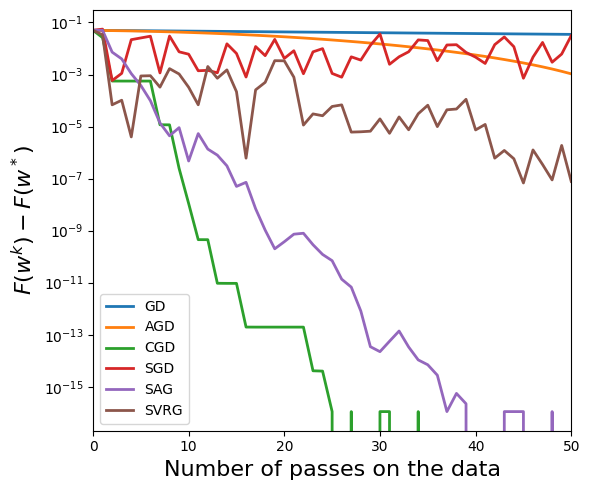

In [42]:
plt.figure(figsize=(6, 5))
plt.yscale("log")

for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    #print(objectives)
    objectives_dist = objectives - obj_min    
    plt.plot(objectives_dist, label=name, lw=2)

plt.tight_layout()
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
plt.legend(loc='lower left')
plt.tight_layout()

### QUESTIONS

1. Compare the minimizers you obtain using the different algorithms, with a large and a small number of iterations. This can be done with `plt.stem` plots.
1. In linear regression and logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.
1. In linear regression and logistic regression, study the influence of the level of ridge penalization on the performance of the optimization algorithms. Explain.
1. (OPTIONAL) All algorithms can be modified to handle an objective of the form $f + g$ with $g$ separable and prox-capable. Modify all the algorithms and try them out for L1 penalization: $w \in \mathbb R^d \mapsto \lambda \sum_{j=1}^d |w_j|$.

C:\Users\maxrl\AppData\Local\Temp\ipykernel_2656\2110609988.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  X_sum=np.sum(np.linalg.norm(X[i,:])**2 for i in range(len(X)))


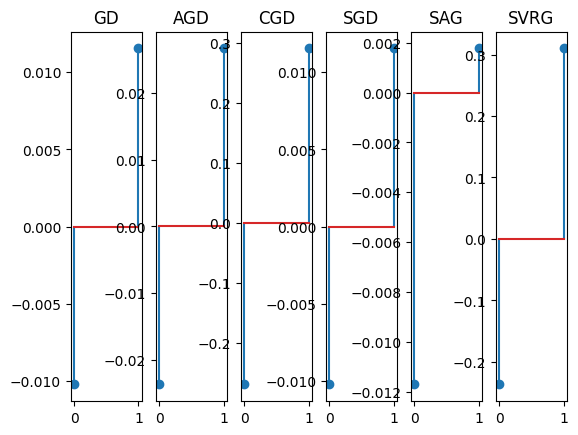

In [43]:
# Answer
#1.

#with a small number of iteration
fonctions=[gd,agd,cgd,gd,sag,sgd,svrg]
fig, axs = plt.subplots(1,6)
for i in range(6):
    if i<4:
        var=fonctions[i](model, w0, n_iter=10, callback=callback_long, verbose=False) 
    elif i==5:
        var=fonctions[i](model, w0, idx_samples, n_iter=10, step=step, callback=callback_sag)
    else:
        var=fonctions[i](model, w0, idx_samples, n_iter=10,step=step, callback=callback_svrg)
    name=names[i]
    axs[i].stem(var)
    axs[i].set_title(name)

plt.show()

C:\Users\maxrl\AppData\Local\Temp\ipykernel_2656\2110609988.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  X_sum=np.sum(np.linalg.norm(X[i,:])**2 for i in range(len(X)))


Lauching AGD solver...
      60 | 6.93e-01
      70 | 6.93e-01
      80 | 6.92e-01
      90 | 6.92e-01
     100 | 6.91e-01
Lauching AGD solver...
     110 | 6.93e-01
     120 | 6.93e-01
     130 | 6.92e-01
     140 | 6.92e-01
     150 | 6.91e-01
Lauching AGD solver...
     160 | 6.93e-01
     170 | 6.93e-01
     180 | 6.93e-01
     190 | 6.92e-01
     200 | 6.92e-01
Lauching AGD solver...
     210 | 6.93e-01
     220 | 6.93e-01
     230 | 6.93e-01
     240 | 6.92e-01
     250 | 6.92e-01
Lauching AGD solver...
     260 | 6.93e-01
     270 | 6.93e-01
     280 | 6.93e-01
     290 | 6.92e-01
     300 | 6.92e-01
Lauching AGD solver...
     310 | 6.93e-01
     320 | 6.93e-01
     330 | 6.93e-01
     340 | 6.93e-01
     350 | 6.92e-01
Lauching AGD solver...
     360 | 6.93e-01
     370 | 6.93e-01
     380 | 6.93e-01
     390 | 6.93e-01
     400 | 6.92e-01
Lauching AGD solver...
     410 | 6.93e-01
     420 | 6.93e-01
     430 | 6.93e-01
     440 | 6.93e-01
     450 | 6.92e-01
Lauching AGD sol

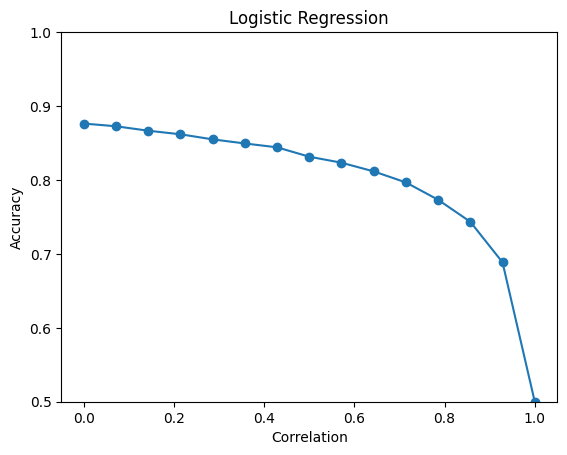

Lauching GD solver...
     820 | 2.41e+00
     830 | 2.41e+00
     840 | 2.41e+00
     850 | 2.41e+00
     860 | 2.41e+00
Lauching GD solver...
     870 | 2.25e+00
     880 | 2.29e+00
     890 | 2.29e+00
     900 | 2.29e+00
     910 | 2.29e+00
Lauching GD solver...
     920 | 6.93e-01
     930 | 2.19e+00
     940 | 2.19e+00
     950 | 2.19e+00
     960 | 2.19e+00
     970 | 2.19e+00
Lauching GD solver...
     980 | 2.11e+00
     990 | 2.11e+00
    1000 | 2.11e+00
    1010 | 2.11e+00
    1020 | 2.11e+00
Lauching GD solver...
    1030 | 1.96e+00
    1040 | 1.96e+00
    1050 | 1.96e+00
    1060 | 1.96e+00
    1070 | 1.96e+00
Lauching GD solver...
    1080 | 1.77e+00
    1090 | 1.83e+00
    1100 | 1.83e+00
    1110 | 1.83e+00
    1120 | 1.83e+00
Lauching GD solver...
    1130 | 1.26e+00
    1140 | 1.69e+00
    1150 | 1.69e+00
    1160 | 1.69e+00
    1170 | 1.69e+00
Lauching GD solver...
    1180 | 6.93e-01
    1190 | 1.54e+00
    1200 | 1.54e+00
    1210 | 1.54e+00
    1220 | 1.54e+00
    

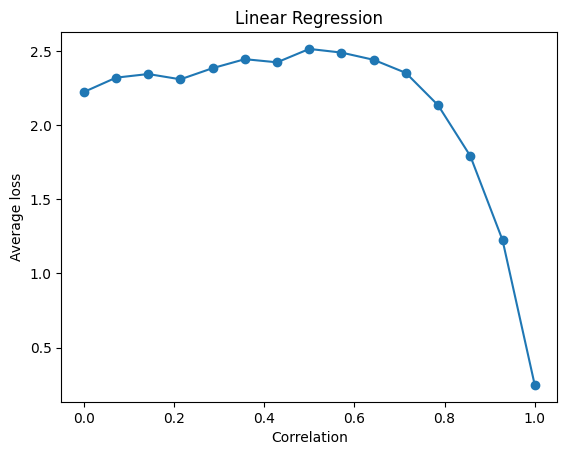

In [44]:
# Answer

corrList=np.linspace(0,1,15)
iterations=50
accuracyLogreg=[]
plt.figure()
n_samples = 100000
train=int((2*n_samples)/3)

for correlation in corrList:
    strenght=0.5
    
    w0 = np.array([-3, 3.])
    X, y = simu_logreg(w0, n_samples=n_samples, corr=correlation)
    X_train=X[0:train]
    y_train=y[0:train]

    X_test=X[train:]
    y_test=y[train:]

    model=ModelLogReg(X_train, y_train, strenght)
    
    w0 = np.zeros(model.n_features)
    w_agd = agd(model, w0, n_iter=n_iter, callback=callback_agd)

    prediction=X_test@w_sag
    prediction=np.sign(prediction)
    acc=np.sum(1*np.equal(prediction,y_test))/len(y_test)
    accuracyLogreg.append(acc)

plt.plot(corrList, np.array(accuracyLogreg))
plt.scatter(corrList, np.array(accuracyLogreg))
plt.xlabel("Correlation")
plt.ylabel("Accuracy")
plt.title("Logistic Regression")
plt.ylim([0.5,1])
plt.show()

accuracyLinReg=[]
plt.figure()

for correlation in corrList:
    strenght=0.5
    w0 = np.array([-3, 3.])
    X, y = simu_linreg(w0, n_samples=n_samples, corr=correlation)
    X_train=X[0:train]
    y_train=y[0:train]

    X_test=X[train:]
    y_test=y[train:]

    model=ModelLinReg(X_train, y_train, strenght)
    
    w0 = np.zeros(model.n_features)
    w_gd = gd(model, w0, n_iter=n_iter, callback=callback_agd)

    loss=y_test-X_test@w_gd
    loss=np.sum(loss**2)/len(loss)
    accuracyLinReg.append(loss)


plt.plot(corrList, np.array(accuracyLinReg))
plt.scatter(corrList, np.array(accuracyLinReg))
plt.xlabel("Correlation")
plt.ylabel("Average loss")
plt.title("Linear Regression")
plt.show()

    
    


Answer question 2: 
As can be seen for the accuracy for Logistic regression, the accuracy plummits to 50% (random guess) when the correlation reaches 1. This is because the datapoints are along a line and cant be distiguished.


The linear regression gets progressivley better as the correlation increases as correlation approaches 1. 

C:\Users\maxrl\AppData\Local\Temp\ipykernel_2656\2110609988.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  X_sum=np.sum(np.linalg.norm(X[i,:])**2 for i in range(len(X)))


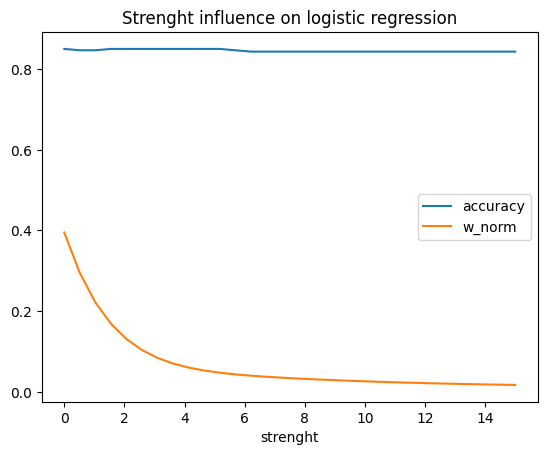

In [45]:
from sklearn.model_selection import train_test_split

strenght_list=np.linspace(0,15,30)
w_norms=[]
accuracys=[]


n_samples = 1000
strenght=0
w0_dataset = np.array([-3, 3.])

X, y = simu_logreg(w0_dataset, n_samples=n_samples, corr=0.4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model=ModelLogReg(X_train,y_train,strenght)
w0=np.zeros(model.n_features)

for strenght in strenght_list:
    model.strength=strenght
    w_agd = agd(model, w0, n_iter=50, callback=callback_long, verbose=False)
    w_norms.append(np.linalg.norm(w_agd))
    prediction=np.sign(X_test@w_agd)
    accuracys.append(1-np.linalg.norm((prediction-y_test),ord=0)/len(y_test))
    #print(strenght)

plt.plot(strenght_list,accuracys,label="accuracy")
plt.plot(strenght_list,w_norms,label="w_norm")
plt.xlabel("strenght")
plt.title("Strenght influence on logistic regression")
plt.legend()
plt.show()

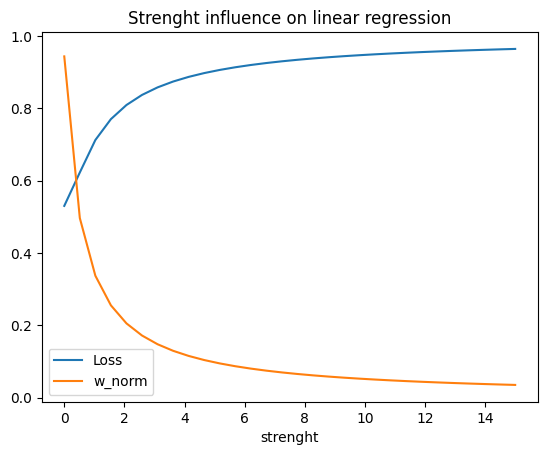

In [46]:
from sklearn.model_selection import train_test_split

strenght_list=np.linspace(0,15,30)
w_norms=[]
accuracys=[]


n_samples = 1000
strenght=0
w0_dataset = np.array([-3, 3.])

X, y = simu_logreg(w0_dataset, n_samples=n_samples, corr=0.4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model=ModelLinReg(X_train,y_train,strenght)
w0=np.zeros(model.n_features)

for strenght in strenght_list:
    model.strength=strenght
    w_agd = agd(model, w0, n_iter=50, callback=callback_long, verbose=False)
    w_norms.append(np.linalg.norm(w_agd))
    loss=y_test-(X_test@w_agd)
    loss=np.sum(loss**2)/len(loss)
    accuracys.append(loss)

plt.plot(strenght_list,accuracys,label="Loss")
plt.plot(strenght_list,w_norms,label="w_norm")
plt.xlabel("strenght")
plt.title("Strenght influence on linear regression")
plt.legend()
plt.show()

Answer question 3:

As can be seen in the graphs, higher penalty leads to a smaller absolute value of $\omega$, as can be seen in the graphs.

As for the accuracy, the logistic regresion is unaffected. This is beacuse the class of y is determined by the sign of $\omega \cdot x$, which is unaffected by the size of $\omega$

The value off the loss-function increses as the penalty increases for linear regression. This is presumably because we are choosing a $\omega$ that isn't optimal since we are penalizing it being having big absolute value.